# ARIMA Lab

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

## Importing the data

### Data checks: 
After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [2]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [3]:
walmart.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [4]:
walmart.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [5]:
walmart.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [11]:
np.unique(walmart.Store)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

In [12]:
np.unique(walmart.Dept)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       54, 55, 56, 58, 59, 60, 65, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82,
       83, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int64)

### Creating a datetime index:

Convert the `Date` column to datetime, and set it as the index for the dataframe.

In [15]:
walmart['Date'] = pd.to_datetime(walmart['Date'])

In [16]:
walmart.set_index('Date', inplace = True)

### Getting weekly sales for store 1:

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **groupby**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [64]:
walmart1 = walmart[walmart['Store'] == 1]

In [69]:
walmart1 = walmart1.groupby('Date')['Weekly_Sales'].sum()

In [72]:
pd.DataFrame(walmart1)

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68
...,...
2012-09-28,1437059.26
2012-10-05,1670785.97
2012-10-12,1573072.81


---

## Plotting and interpreting a time series

### Generate a line plot:

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

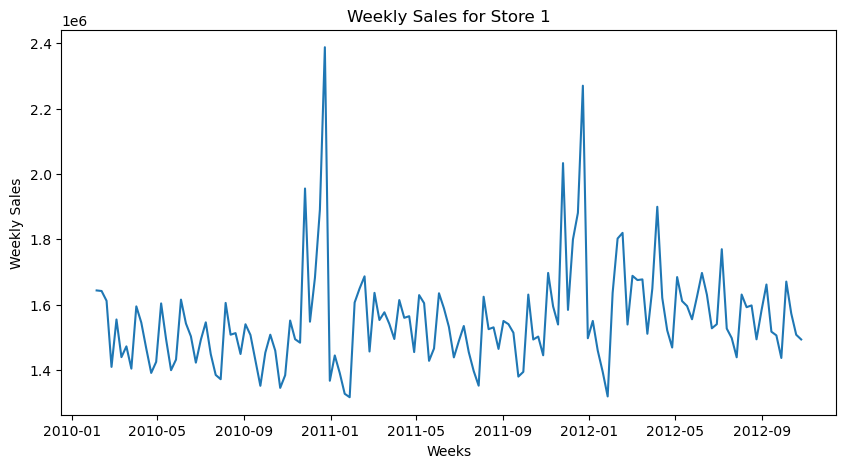

In [82]:
plt.figure(figsize = (10,5))
plt.plot(walmart1)
plt.ylabel('Weekly Sales')
plt.xlabel('Weeks')
plt.title('Weekly Sales for Store 1');

### Plotting rolling means:

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

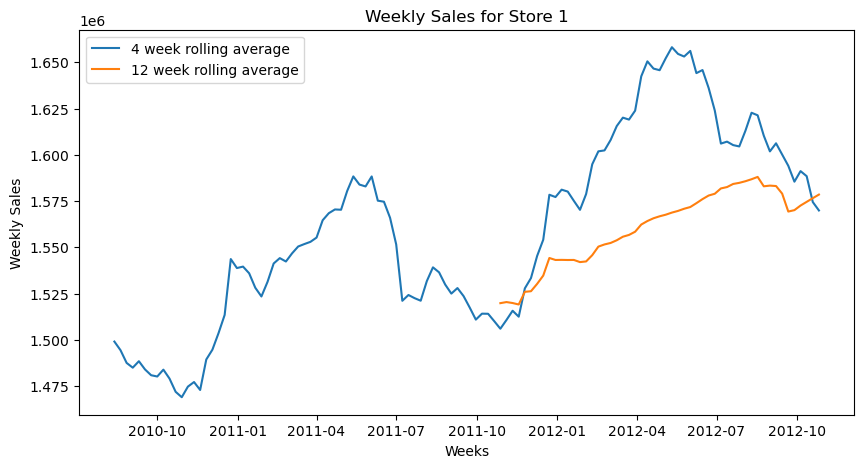

In [85]:
plt.figure(figsize = (10,5))
plt.plot(walmart1.rolling(28).mean(), label = '4 week rolling average')
plt.plot(walmart1.rolling(91).mean(), label = '12 week rolling average')
plt.ylabel('Weekly Sales')
plt.xlabel('Weeks')
plt.title('Weekly Sales for Store 1')
plt.legend();

### (Short answer) Describe any trends that you notice:

- Smoother than just weekly data along
- Spike around holidays
- General upward trend over time

---

## Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

### Plot and interpret the autocorrelation:

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. What do you notice? (Your answer can be given in bullet points; full sentences are not required.)

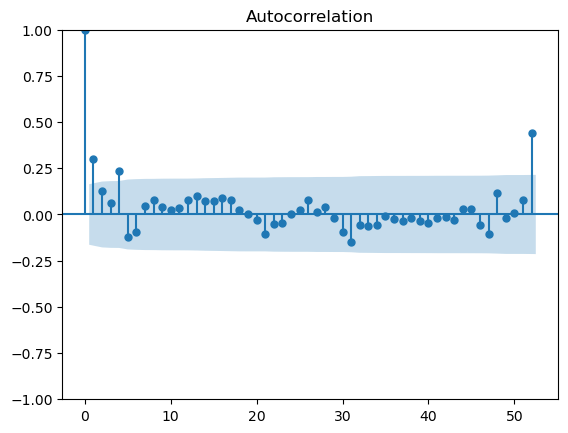

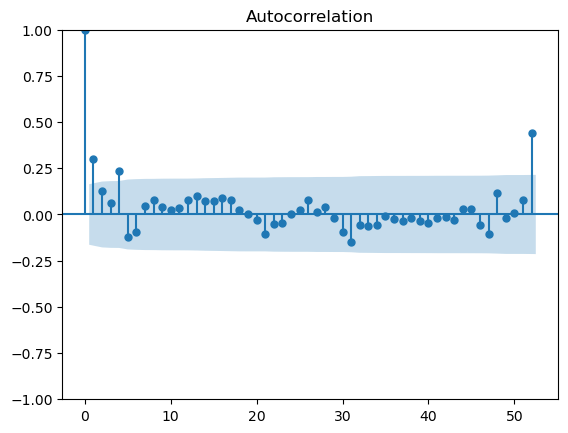

In [96]:
plot_acf(walmart1, lags=52)

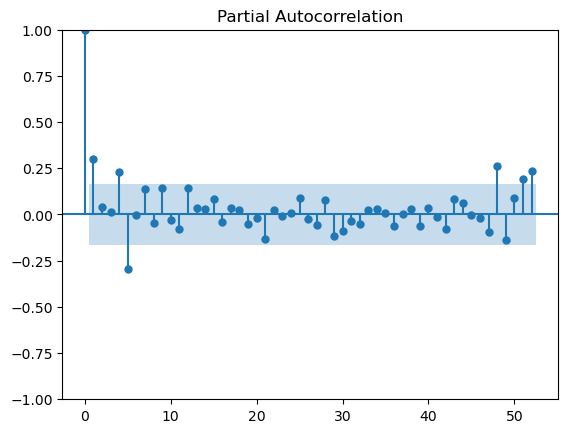

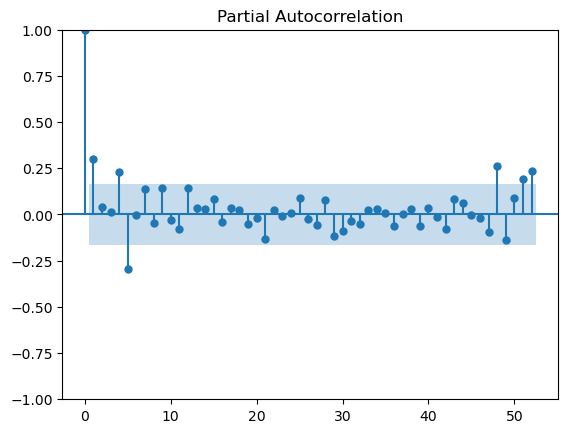

In [93]:
plot_pacf(walmart1, lags=52)

- There is seasonality 
- Autocorrelation is higher on annual/end of yr basis 

---

## Modeling

### Train-test splitting:

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [123]:
y_train, y_test = train_test_split(walmart1, test_size = 0.1, shuffle = False)

### Evaluating stationarity:

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [124]:
adfuller(walmart1)

(-5.102186145192289,
 1.3877788330759307e-05,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 3412.7325502876756)

---

### Fit and evaluate an AR(1) model:

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data:

In [107]:
model = ARIMA(y_train, order = (1,0,0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1710.923
Date:                Tue, 28 Nov 2023   AIC                           3427.846
Time:                        14:16:19   BIC                           3436.402
Sample:                    02-05-2010   HQIC                          3431.323
                         - 07-13-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.556e+06   2.31e+04     67.488      0.000    1.51e+06     1.6e+06
ar.L1          0.3081      0.050      6.118      0.000       0.209       0.407
sigma2      2.397e+10      0.172   1.39e+11      0.000     2.4e+10     2.4e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               204.46
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.57   Skew:                             1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.53e+26. Standard errors may be unstable.
"""

### Evaluating the model:

#### Store predictions:

Remember that statsmodels ARIMA models generate predictions off of `start` and `end` dates.

Generate and store predictions for the training and testing data:

In [109]:
y_forecast = model.predict(start=y_test.index[0], end = y_test.index[-1])

#### Mean squared error:

Use the `mean_squared_error` function to identify the MSE on the testing data:

In [110]:
mean_squared_error(y_test, y_forecast)

5188882502.605215

#### Generate a plot of the training data, testing data, train preds, and test preds:

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

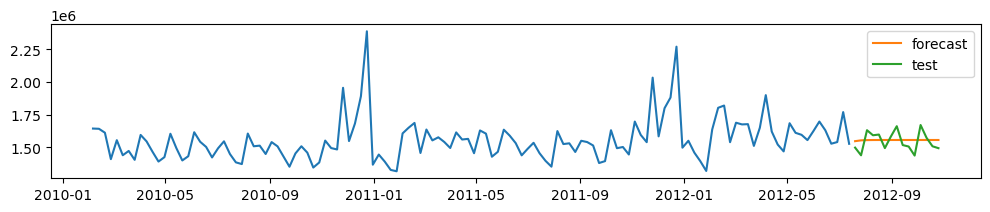

In [119]:
plt.figure(figsize=(12,2))
plt.plot(y_train)
plt.plot(y_forecast, label = 'forecast')
plt.plot(y_test, label = 'test')
plt.legend();

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

- Not very good, predicts flat line basically

---

### Fit and evaluate an ARMA(2,2) model:

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [128]:
model = ARIMA(y_train, order = (2,0,2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1701.493
Date:                Tue, 28 Nov 2023   AIC                           3414.985
Time:                        14:26:32   BIC                           3432.097
Sample:                    02-05-2010   HQIC                          3421.938
                         - 07-13-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.556e+06   2.38e+04     65.255      0.000    1.51e+06     1.6e+06
ar.L1         -1.0500      0.072    -14.590      0.000      -1.191      -0.909
ar.L2         -0.4778      0.066     -7.191      0.000      -0.608      -0.348
ma.L1          1.4604      0.072     20.411      0.000       1.320       1.601
ma.L2          0.9825      0.088     11.217      0.000       0.811       1.154
sigma2      2.279e+10      0.059   3.83e+11      0.000    2.28e+10    2.28e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                74.46
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                             1.36
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.28e+26. Standard errors may be unstable.
"""

### Evaluating the model:

#### Store predictions:

Generate and store predictions for train and test:

In [129]:
y_forecast = model.predict(start=y_test.index[0], end = y_test.index[-1])

#### Mean squared error:

Find the MSE of the testing data:

In [130]:
mean_squared_error(y_test, y_forecast)

4617983814.528623

#### Generate a plot of the training data, testing data, train preds, and test preds:

As before, plot your data and predictions.

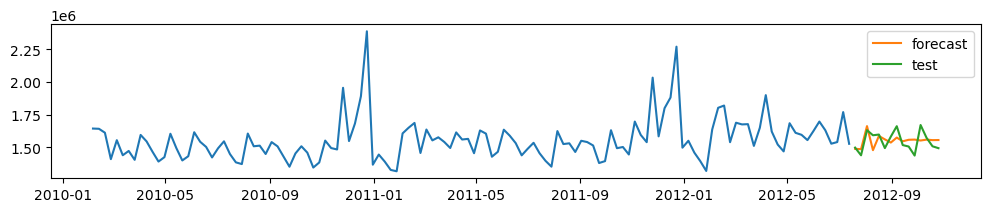

In [131]:
plt.figure(figsize=(12,2))
plt.plot(y_train)
plt.plot(y_forecast, label = 'forecast')
plt.plot(y_test, label = 'test')
plt.legend();

#### Intepretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

- A bit better in the short-term, but then flat line basically

---

### Fit and evaluate an ARIMA(2,1,2) model:

Instantiate and fit an ARIMA model with order $(2,1,2)$:

In [141]:
model = ARIMA(y_train, order = (2,1,2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1707.922
Date:                Tue, 28 Nov 2023   AIC                           3425.845
Time:                        14:27:56   BIC                           3440.066
Sample:                    02-05-2010   HQIC                          3431.623
                         - 07-13-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4178      0.280     -1.494      0.135      -0.966       0.130
ar.L2          0.4121      0.101      4.100      0.000       0.215       0.609
ma.L1         -0.1075      0.278     -0.387      0.699      -0.651       0.436
ma.L2         -0.7808      0.229     -3.408      0.001      -1.230      -0.332
sigma2      2.948e+10   1.54e-11   1.91e+21      0.000    2.95e+10    2.95e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                69.87
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                             0.71
Prob(H) (two-sided):                  0.20   Kurtosis:                         6.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.32e+36. Standard errors may be unstable.
"""

### Evaluating the model:

#### Store predictions:

Generate and store predictions for train and test:

In [142]:
y_forecast = model.predict(start=y_test.index[0], end = y_test.index[-1])

#### Mean squared error:

Find the MSE on your testing data:

In [143]:
mean_squared_error(y_test, y_forecast)

8383610184.741395

#### Generate a plot of the training data, testing data, train preds and test preds:

As before, plot your data and predictions.

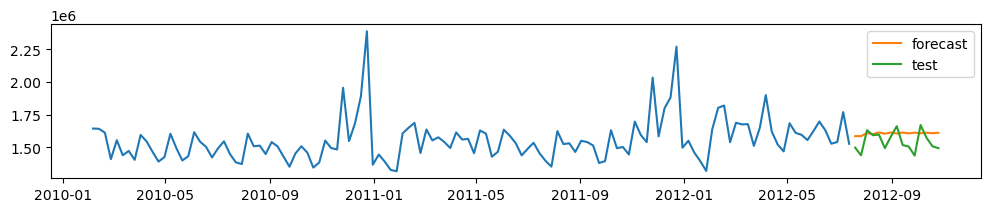

In [144]:
plt.figure(figsize=(12,2))
plt.plot(y_train)
plt.plot(y_forecast, label = 'forecast')
plt.plot(y_test, label = 'test')
plt.legend();

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

- Bad - flat line basically

---

### Fit and evaluate an ARIMA(52,0,1) model:

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$:

In [145]:
model = ARIMA(y_train, order = (52,0,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                ARIMA(52, 0, 1)   Log Likelihood               -1642.421
Date:                Tue, 28 Nov 2023   AIC                           3394.841
Time:                        14:28:37   BIC                           3551.703
Sample:                    02-05-2010   HQIC                          3458.575
                         - 07-13-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.556e+06    2.7e-07   5.76e+12      0.000    1.56e+06    1.56e+06
ar.L1          0.0623      0.148      0.421      0.674      -0.228       0.352
ar.L2          0.1182      0.119      0.997      0.319      -0.114       0.351
ar.L3         -0.1133      0.086     -1.311      0.190      -0.283       0.056
ar.L4          0.0961      0.101      0.947      0.343      -0.103       0.295
ar.L5         -0.0462      0.106     -0.437      0.662      -0.253       0.161
ar.L6         -0.0785      0.098     -0.798      0.425      -0.271       0.114
ar.L7          0.1435      0.081      1.777      0.075      -0.015       0.302
ar.L8         -0.0678      0.074     -0.922      0.357      -0.212       0.076
ar.L9          0.0444      0.097      0.457      0.648      -0.146       0.235
ar.L10         0.0327      0.081      0.401      0.688      -0.127       0.192
ar.L11        -0.0736      0.075     -0.977      0.328      -0.221       0.074
ar.L12         0.1458      0.086      1.696      0.090      -0.023       0.314
ar.L13         0.0004      0.088      0.005      0.996      -0.171       0.172
ar.L14         0.0023      0.087      0.026      0.979      -0.169       0.174
ar.L15         0.1028      0.070      1.461      0.144      -0.035       0.241
ar.L16        -0.0452      0.073     -0.620      0.536      -0.188       0.098
ar.L17         0.0599      0.079      0.754      0.451      -0.096       0.215
ar.L18         0.0228      0.083      0.275      0.783      -0.140       0.186
ar.L19        -0.0196      0.097     -0.202      0.840      -0.210       0.171
ar.L20         0.0515      0.082      0.624      0.532      -0.110       0.213
ar.L21        -0.0261      0.095     -0.274      0.784      -0.213       0.161
ar.L22         0.0323      0.116      0.277      0.781      -0.196       0.260
ar.L23         0.0068      0.113      0.060      0.952      -0.214       0.227
ar.L24        -0.0585      0.086     -0.683      0.495      -0.226       0.109
ar.L25         0.0555      0.103      0.538      0.591      -0.147       0.258
ar.L26        -0.0326      0.097     -0.338      0.736      -0.222       0.157
ar.L27         0.0035      0.109      0.032      0.975      -0.210       0.217
ar.L28         0.0538      0.091      0.592      0.554      -0.124       0.232
ar.L29        -0.0347      0.079     -0.438      0.661      -0.190       0.121
ar.L30         0.0165      0.128      0.129      0.897      -0.234       0.267
ar.L31        -0.0868      0.110     -0.787      0.431      -0.303       0.129
ar.L32         0.0015      0.103      0.015      0.988      -0.200       0.203
ar.L33         0.0322      0.108      0.298      0.766      -0.180       0.244
ar.L34        -0.0885      0.128     -0.692      0.489      -0.339       0.162
ar.L35         0.0536      0.126      0.425      0.670      -0.193       0.301
ar.L36        -0.0664      0.087     -0.764      0.445      -0.237       0.104
ar.L37        -0.0813      0.082     -0.987      0.324      -0.243       0.080
ar

### Evaluating the model:

#### Store predictions:

Generate and store predictions for train and test:

In [146]:
y_forecast = model.predict(start=y_test.index[0], end = y_test.index[-1])

#### Mean squared error:

Find the MSE on your testing data:

In [147]:
mean_squared_error(y_test, y_forecast)

7894094705.380032

#### Generate a plot of the training data, testing data, train preds and test preds:

As before, plot your data and predictions.

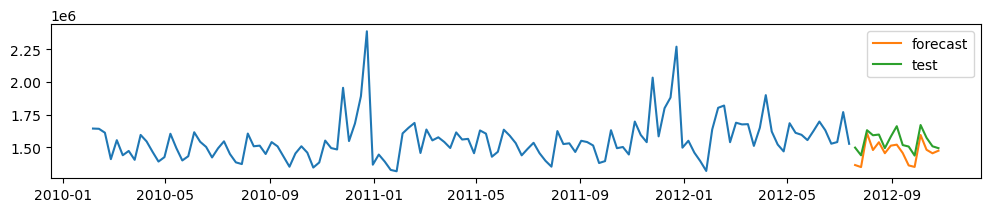

In [148]:
plt.figure(figsize=(12,2))
plt.plot(y_train)
plt.plot(y_forecast, label = 'forecast')
plt.plot(y_test, label = 'test')
plt.legend();

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

- Pretty good - very close to actual with similar dips/patterns

---

## (BONUS) SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows exogenous data to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.